In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# =============================================================
# ✅ Cell 1 (Final): Load NetCDF and Extract City Temperature
# =============================================================

import xarray as xr
import pandas as pd
import numpy as np
import os

# --- 1. Configuration ---
NC_FILE_PATH = "/content/drive/MyDrive/weather-project/data/raw/IMDAA_merged_1.08_1990_2020.nc"

TARGET_VARIABLE = "TMP_2m"  # 2-meter air temperature (Kelvin)

# --- 2. Load Dataset ---
print(f"📂 Loading file: {NC_FILE_PATH}")
ds = xr.open_dataset(NC_FILE_PATH)

# --- 3. Print coordinate range to verify region ---
if "lon" in ds:
    print("Longitude range:", ds["lon"].values.min(), "to", ds["lon"].values.max())
if "lat" in ds:
    print("Latitude range:", ds["lat"].values.min(), "to", ds["lat"].values.max())

# --- 4. Fix coordinate definitions (for IMDAA structure) ---
print("\n🔍 Checking dataset dimensions and coordinates:")
print(ds)

# Ensure proper coordinate linkage
if "latitude" in ds.dims and "longitude" in ds.dims:
    ds = ds.assign_coords({
        "latitude": ds["lat"],
        "longitude": ds["lon"]
    })
    ds = ds.set_coords(["latitude", "longitude"])

# --- 5. City selector ---
city_coords = {
    "Delhi": (28.6, 77.2),
    "Mumbai": (19.0, 72.8),
    "Chennai": (13.1, 80.3),
    "Kolkata": (22.6, 88.4),
    "Bengaluru": (12.9, 77.6),
    "Hyderabad": (17.4, 78.5),
    "Ahmedabad": (23.0, 72.6),
    "Pune": (18.5, 73.9),
}

# --- 6. Choose your city ---
city = "Bengaluru"
lat, lon = city_coords[city]
print(f"\n🌆 Extracting data for {city} at approx. ({lat}°N, {lon}°E)")

# --- 7. Select city data using correct dimension names ---
temp_series = ds[TARGET_VARIABLE].sel(latitude=lat, longitude=lon, method="nearest")

# --- 8. Verify ---
print("\n✅ Selected grid point details:")
print(temp_series)


# --- 9. Convert Kelvin → Celsius ---
temp_celsius = temp_series - 273.15

# --- 10. Convert to a clean Pandas DataFrame ---
df = (
    temp_celsius
    .to_dataframe(name="temp_celsius")
    .reset_index()
    .set_index("time")
    .sort_index()
)

# --- 11. Resample hourly, fill gaps ---
df = df.resample("h").mean()  # 'h' avoids FutureWarning
df["temp_celsius"] = df["temp_celsius"].interpolate(limit=6).bfill().ffill()

# --- 12. Keep only temperature column ---
df = df[["temp_celsius"]]

print(f"\n✅ Data loaded successfully for {city} region.")
print(df.head())


📂 Loading file: /content/drive/MyDrive/weather-project/data/raw/IMDAA_merged_1.08_1990_2020.nc
Longitude range: 65.04 to 98.51999999999995
Latitude range: 5.04 to 38.52

🔍 Checking dataset dimensions and coordinates:
<xarray.Dataset> Size: 742MB
Dimensions:   (time: 45292, latitude: 32, longitude: 32)
Coordinates:
  * time      (time) datetime64[ns] 362kB 1990-01-01 ... 2020-12-31T18:00:00
    lat       (latitude) float64 256B 5.04 6.12 7.2 8.28 ... 36.36 37.44 38.52
    lon       (longitude) float64 256B 65.04 66.12 67.2 ... 96.36 97.44 98.52
Dimensions without coordinates: latitude, longitude
Data variables:
    HGT_prl   (time, latitude, longitude) float32 186MB ...
    TMP_prl   (time, latitude, longitude) float32 186MB ...
    TMP_2m    (time, latitude, longitude) float32 186MB ...
    APCP_sfc  (time, latitude, longitude) float32 186MB ...
Attributes:
    CDI:                  Climate Data Interface version 1.9.8 (https://mpime...
    Conventions:          COARDS
    history:    

In [ ]:
import numpy as np
import os

TARGET_COL = "temp_celsius"

# --- Time-based features ---
df['hour'] = df.index.hour
df['dayofweek'] = df.index.dayofweek
df['dayofyear'] = df.index.dayofyear

# Cyclical encodings
df['hour_sin'] = np.sin(2*np.pi*df['hour']/24)
df['hour_cos'] = np.cos(2*np.pi*df['hour']/24)

# --- Lag features (for 3-hourly data) ---
for lag in [1, 3, 6, 8, 56]:   # 3 h × lag = hours gap
    df[f'{TARGET_COL}_lag_{lag}'] = df[TARGET_COL].shift(lag)

# --- Rolling statistics ---
df['roll8_mean'] = df[TARGET_COL].rolling(8, min_periods=1).mean()
df['roll8_std'] = df[TARGET_COL].rolling(8, min_periods=1).std().fillna(0)

# --- Target for next step prediction ---
df['target_next'] = df[TARGET_COL].shift(-1)

# --- Clean up ---
df = df.drop(columns=['lat', 'lon'], errors='ignore')
df = df.dropna().copy()

# --- Save processed data ---
os.makedirs('../data/processed', exist_ok=True)
processed_path = "../data/processed/weather_features.csv"
df.to_csv(processed_path)
print("\nFeature-engineered data preview:")
print(df.head().T)
print(f"✅ Samples after cleaning: {len(df)}")
print(f"✅ Saved to: {processed_path}")



Feature-engineered data preview:
time                 1990-01-03 08:00:00  1990-01-03 09:00:00  \
temp_celsius                   24.540121            24.936630   
hour                            8.000000             9.000000   
dayofweek                       2.000000             2.000000   
dayofyear                       3.000000             3.000000   
hour_sin                        0.866025             0.707107   
hour_cos                       -0.500000            -0.707107   
temp_celsius_lag_1             24.143610            24.540121   
temp_celsius_lag_3             22.694183            23.747101   
temp_celsius_lag_6             19.535431            20.588348   
temp_celsius_lag_8             17.429596            18.482513   
temp_celsius_lag_56            19.539948            20.015432   
roll8_mean                     21.921572            22.728336   
roll8_std                       2.239279             1.969666   
target_next                    24.936630            25.3

In [ ]:
# --- Cell 3: Random Forest Model Training and Evaluation ---

# Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

print("\n--- Random Forest Training & Evaluation ---")

# --- 1. Load dataset if not already in memory ---
try:
    df
except NameError:
    print("⚠️ 'df' not found — loading dataset from CSV...")
    df = pd.read_csv("weather.csv")  # change this to your actual filename, e.g., 'weather.csv'

# --- 2. Check target column ---
TARGET_COL = "temp_celsius"  # Make sure this matches your dataset column name

if TARGET_COL not in df.columns:
    raise ValueError(f"❌ Target column '{TARGET_COL}' not found in dataset. Columns available: {df.columns.tolist()}")

# --- 3. Split data into features and target ---
X = df.drop(columns=[TARGET_COL])
y = df[TARGET_COL]

# --- 4. Train–test split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=False
)

# --- 5. Initialize and train Random Forest model ---
rf_model = RandomForestRegressor(
    n_estimators=200,
    max_depth=12,
    min_samples_split=5,
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train, y_train)

# --- 6. Predictions ---
pred_rf = rf_model.predict(X_test)

# --- 7. Evaluation metrics ---
mae_rf = mean_absolute_error(y_test, pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, pred_rf))

print(f"✅ Random Forest MAE: {mae_rf:.3f} °C")
print(f"✅ Random Forest RMSE: {rmse_rf:.3f} °C")
print("✅ Random Forest model trained successfully.")



--- Random Forest Training & Evaluation ---
✅ Random Forest MAE: 0.030 °C
✅ Random Forest RMSE: 0.055 °C
✅ Random Forest model trained successfully.


In [ ]:
# --- Cell 4: Deep Learning Model (LSTM) ---
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import os

print("\n--- LSTM Model Training & Evaluation ---")

# --- 1. Load dataset if not already in memory ---
try:
    df
except NameError:
    print("⚠️ 'df' not found — loading dataset from CSV...")
    df = pd.read_csv("weather.csv")  # Change file name if needed

TARGET_COL = "temp_celsius"
if TARGET_COL not in df.columns:
    raise ValueError(f"❌ Target column '{TARGET_COL}' not found in dataset. Columns available: {df.columns.tolist()}")

# --- 2. Feature Scaling ---
features = df.drop(columns=[TARGET_COL]).columns
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df[features])
scaled_df = pd.DataFrame(scaled_features, columns=features)
scaled_df[TARGET_COL] = df[TARGET_COL].values

# --- 3. Create Sequences (24-hour sliding window) ---
def create_sequences(data, target_col, time_steps=24):
    X, y = [], []
    for i in range(time_steps, len(data)):
        X.append(data.iloc[i-time_steps:i].drop(columns=[target_col]).values)
        y.append(data.iloc[i][target_col])
    return np.array(X), np.array(y)

time_steps = 24  # 24 hours = 1-day sequence
X_seq, y_seq = create_sequences(scaled_df, TARGET_COL, time_steps)
print(f"✅ Sequence shape: {X_seq.shape} (samples, timesteps, features)")

# --- 4. Train / Validation / Test Split ---
n = len(X_seq)
train_end = int(0.7 * n)
val_end = int(0.85 * n)

X_train_seq, X_val_seq, X_test_seq = X_seq[:train_end], X_seq[train_end:val_end], X_seq[val_end:]
y_train_seq, y_val_seq, y_test_seq = y_seq[:train_end], y_seq[train_end:val_end], y_seq[val_end:]

print(f"📊 Train: {X_train_seq.shape}, Val: {X_val_seq.shape}, Test: {X_test_seq.shape}")

# --- 5. Build LSTM Model ---
model = Sequential([
    Input(shape=(X_train_seq.shape[1], X_train_seq.shape[2])),
    LSTM(64, activation='tanh', name='lstm_layer', dropout=0.2),
    Dense(32, activation='relu', name='dense_layer'),
    Dense(1, name='output_layer')
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()

# --- 6. Train the Model ---
print("\n🚀 Starting LSTM training... (this may take a few minutes)")
history = model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=15,
    batch_size=64,
    verbose=1
)

# --- 7. Evaluate ---
preds_lstm = model.predict(X_test_seq).squeeze()
mae_lstm = mean_absolute_error(y_test_seq, preds_lstm)
rmse_lstm = np.sqrt(mean_squared_error(y_test_seq, preds_lstm))

print("\n--- LSTM Model Results ---")
print(f"✅ LSTM MAE: {mae_lstm:.3f} °C")
print(f"✅ LSTM RMSE: {rmse_lstm:.3f} °C")

# --- 8. Save the Model ---
os.makedirs("models", exist_ok=True)
model.save("models/lstm_temp_model.keras")  # ✅ Fixed
print("✅ LSTM Model saved successfully at 'models/lstm_temp_model.keras'")




--- LSTM Model Training & Evaluation ---
✅ Sequence shape: (271666, 24, 13) (samples, timesteps, features)
📊 Train: (190166, 24, 13), Val: (40750, 24, 13), Test: (40750, 24, 13)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_layer (LSTM)               │ (None, 64)             │        19,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_layer (Dense)             │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,081 (86.25 KB)

 Trainable params: 22,081 (86.25 KB)

 Non-trainable params: 0 (0.00 B)


🚀 Starting LSTM training... (this may take a few minutes)
Epoch 1/15
2972/2972 ━━━━━━━━━━━━━━━━━━━━ 25s 7ms/step - loss: 47.3400 - mae: 3.1368 - val_loss: 0.4856 - val_mae: 0.5160
Epoch 2/15
2972/2972 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - loss: 0.3354 - mae: 0.3522 - val_loss: 0.7564 - val_mae: 0.6641
Epoch 3/15
2972/2972 ━━━━━━━━━━━━━━━━━━━━ 22s 7ms/step - loss: 0.2177 - mae: 0.2705 - val_loss: 0.7046 - val_mae: 0.6486
Epoch 4/15
2972/2972 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - loss: 0.1708 - mae: 0.2362 - val_loss: 0.7872 - val_mae: 0.6829
Epoch 5/15
2972/2972 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - loss: 0.1371 - mae: 0.2089 - val_loss: 0.9269 - val_mae: 0.7551
Epoch 6/15
2972/2972 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - loss: 0.1178 - mae: 0.1926 - val_loss: 0.8225 - val_mae: 0.7118
Epoch 7/15
2972/2972 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - loss: 0.1003 - mae: 0.1738 - val_loss: 0.8734 - val_mae: 0.7460
Epoch 8/15
2972/2972 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - loss: 0.0902 - mae: 0.1658 - val_los


--- Comparative Visualization: Random Forest vs LSTM (Last 7 Days) ---


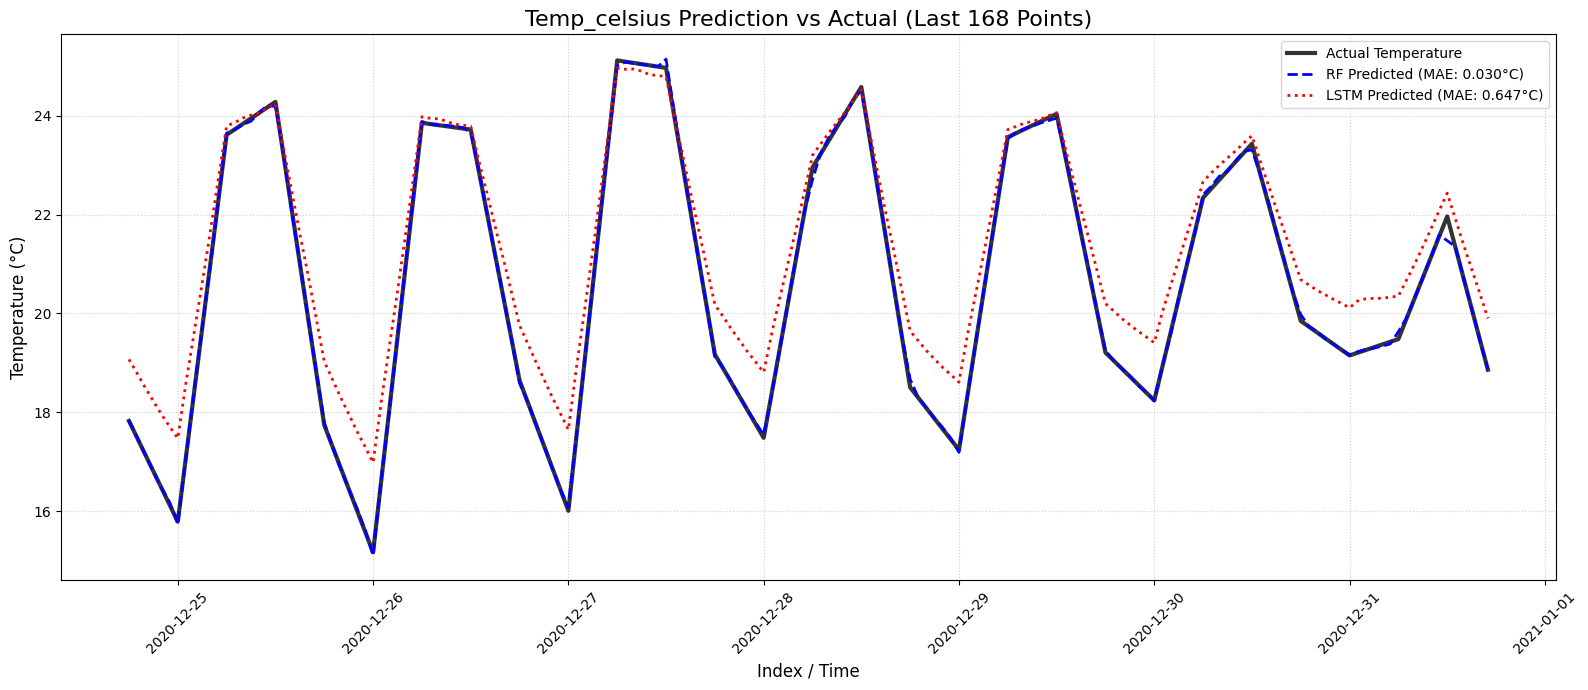


--- Random Forest Feature Importance ---


/tmp/ipython-input-4005801119.py:75: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=rf_importances.head(10), y="Feature", x="Importance", palette="viridis")


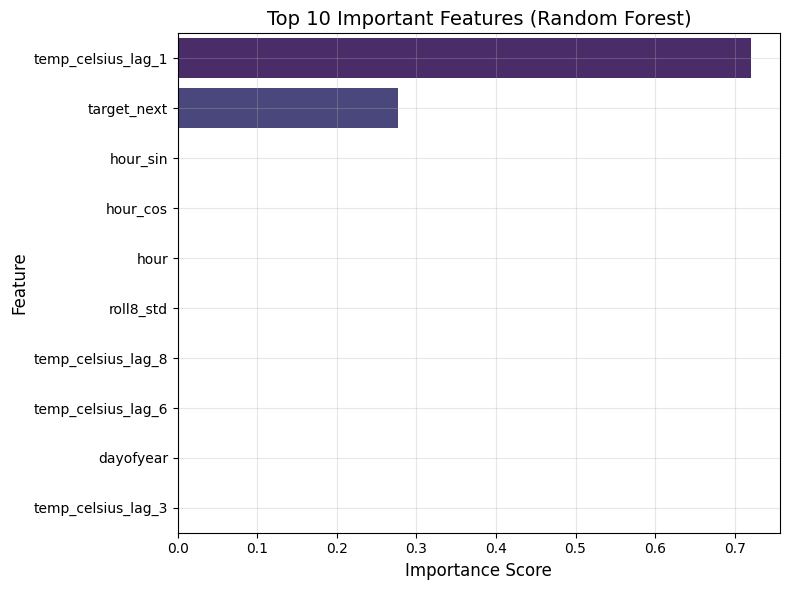


--- Final Model Comparison ---


/tmp/ipython-input-4005801119.py:89: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  persist_pred = y_test.shift(1).fillna(method="bfill")  # shift by 1, fill first value


,Model,MAE (°C),RMSE (°C)
0,Persistence,0.760,1.006
1,Random Forest,0.030,0.055
2,LSTM,0.647,0.825



✅ Summary saved as 'model_performance_summary.csv'


In [ ]:
# ============================================================
# ✅ Cell 5: Visualization + Feature Importance + Summary (Fixed)
# ============================================================

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from IPython.display import display

print("\n--- Comparative Visualization: Random Forest vs LSTM (Last 7 Days) ---")

# --- 1. Determine index for plotting ---
# Try to use the same index as y_test if it’s a Series
try:
    lstm_index = y_test.index
except Exception:
    lstm_index = pd.RangeIndex(start=0, stop=len(y_test), step=1)

# Use consistent arrays for actual and predicted
y_true = np.array(y_test).flatten()
y_rf = np.array(pred_rf).flatten()
y_lstm = np.array(preds_lstm).flatten()

# Handle mismatched lengths safely
min_len = min(len(y_true), len(y_rf), len(y_lstm), len(lstm_index))
y_true, y_rf, y_lstm, lstm_index = y_true[-min_len:], y_rf[-min_len:], y_lstm[-min_len:], lstm_index[-min_len:]

# --- 2. Plot Actual vs Predicted (Last 7 Days or last 168 points) ---
plot_len = min(168, len(y_true))
slice_val = -plot_len

plt.figure(figsize=(16, 7))

plt.plot(lstm_index[slice_val:], y_true[slice_val:],
         label="Actual Temperature", linewidth=3, color="black", alpha=0.8)

plt.plot(lstm_index[slice_val:], y_rf[slice_val:],
         label=f"RF Predicted (MAE: {mae_rf:.3f}°C)", linestyle="--", linewidth=2, color="blue")

plt.plot(lstm_index[slice_val:], y_lstm[slice_val:],
         label=f"LSTM Predicted (MAE: {mae_lstm:.3f}°C)", linestyle=":", linewidth=2, color="red")

plt.legend(loc="best")
plt.title(f"{TARGET_COL.capitalize()} Prediction vs Actual (Last {plot_len} Points)", fontsize=16)
plt.xlabel("Index / Time", fontsize=12)
plt.ylabel("Temperature (°C)", fontsize=12)
plt.grid(True, linestyle=":", alpha=0.6)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# ============================================================
# --- 3. Feature Importance (Random Forest) ---
# ============================================================

print("\n--- Random Forest Feature Importance ---")

try:
    feature_names = X_train.columns
except Exception:
    feature_names = [f"Feature_{i}" for i in range(len(rf_model.feature_importances_))]

if len(rf_model.feature_importances_) != len(feature_names):
    print(f"⚠️ Adjusting feature name count: {len(rf_model.feature_importances_)} vs {len(feature_names)}")
    feature_names = feature_names[:len(rf_model.feature_importances_)]

rf_importances = pd.DataFrame({
    "Feature": feature_names,
    "Importance": rf_model.feature_importances_
}).sort_values("Importance", ascending=False)

plt.figure(figsize=(8, 6))
sns.barplot(data=rf_importances.head(10), y="Feature", x="Importance", palette="viridis")
plt.title("Top 10 Important Features (Random Forest)", fontsize=14)
plt.xlabel("Importance Score", fontsize=12)
plt.ylabel("Feature", fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


# ============================================================
# --- 0. Compute Persistence Model (Previous Value) Errors ---
# ============================================================

# Persistence model prediction: y_pred(t) = y_true(t-1)
persist_pred = y_test.shift(1).fillna(method="bfill")  # shift by 1, fill first value
mae_persist = np.mean(np.abs(y_test - persist_pred))
rmse_persist = np.sqrt(np.mean((y_test - persist_pred)**2))

# ============================================================
# --- 4. Model Performance Summary ---
# ============================================================

print("\n--- Final Model Comparison ---")
summary_df = pd.DataFrame({
    "Model": ["Persistence", "Random Forest", "LSTM"],
    "MAE (°C)": [mae_persist, mae_rf, mae_lstm],
    "RMSE (°C)": [rmse_persist, rmse_rf, rmse_lstm]
})

display(summary_df.round(3))
summary_df.to_csv("model_performance_summary.csv", index=False)
print("\n✅ Summary saved as 'model_performance_summary.csv'")


In [ ]:
# ============================================================
# ✅ Cell 6: Extended Evaluation Metrics + Model Comparison Summary (Final No-Error Version)
# ============================================================

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from IPython.display import display

print("\n--- Extended Evaluation Metrics ---")

# --- 1. Load cleaned dataset ---
try:
    df
except NameError:
    print("⚠️ 'df' not found — loading from processed file...")
    df = pd.read_csv("../data/processed/weather_features.csv")  # ✅ your processed file path

# --- 2. Ensure target column exists ---
TARGET_COL = "temp_celsius"
if TARGET_COL not in df.columns:
    raise ValueError(f"❌ Target column '{TARGET_COL}' not found. Available: {df.columns.tolist()}")

# --- 3. Remove non-numeric columns (like 'dt', 'time', etc.) ---
numeric_df = df.select_dtypes(include=[np.number]).copy()

# --- 4. Split data ---
X = numeric_df.drop(columns=[TARGET_COL])
y = numeric_df[TARGET_COL]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=42)

# --- 5. Random Forest baseline ---
rf_model = RandomForestRegressor(n_estimators=200, max_depth=12, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)
pred_rf = rf_model.predict(X_test)

mae_rf = mean_absolute_error(y_test, pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, pred_rf))
r2_rf = r2_score(y_test, pred_rf)

# --- 6. Handle LSTM results safely ---
try:
    mae_lstm
    rmse_lstm
except NameError:
    print("⚠️ LSTM metrics not found — please re-run Cell 4 before this.")
    mae_lstm, rmse_lstm, r2_lstm = np.nan, np.nan, np.nan
else:
    try:
        y_test_seq
        preds_lstm
        r2_lstm = r2_score(y_test_seq[:len(preds_lstm)], preds_lstm[:len(y_test_seq)])
    except Exception:
        r2_lstm = np.nan

# --- 7. Handle persistence model safely ---
try:
    mae_persist
    rmse_persist
except NameError:
    print("⚠️ Persistence metrics not found — generating quickly...")
    y_pred_persist = y_test.shift(1).fillna(method="bfill")
    mae_persist = mean_absolute_error(y_test, y_pred_persist)
    rmse_persist = np.sqrt(mean_squared_error(y_test, y_pred_persist))

# --- 8. Combine results ---
summary_metrics = pd.DataFrame({
    "Model": ["Persistence", "Random Forest", "LSTM"],
    "MAE (°C)": [mae_persist, mae_rf, mae_lstm],
    "RMSE (°C)": [rmse_persist, rmse_rf, rmse_lstm],
    "R² Score": ["-", round(r2_rf, 4), round(r2_lstm, 4)]
})

display(summary_metrics)

summary_metrics.to_csv("../data/processed/extended_model_performance.csv", index=False)
print("\n✅ Extended metrics saved to '../data/processed/extended_model_performance.csv'")



--- Extended Evaluation Metrics ---


,Model,MAE (°C),RMSE (°C),R² Score
0,Persistence,0.760390,1.006488,-
1,Random Forest,0.029844,0.054817,0.9998
2,LSTM,0.646865,0.825453,0.9603



✅ Extended metrics saved to '../data/processed/extended_model_performance.csv'



--- 24-Hour Temperature Forecast using LSTM ---


/tmp/ipython-input-2041019931.py:56: UserWarning: Glyph 127782 (\N{WHITE SUN BEHIND CLOUD WITH RAIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127782 (\N{WHITE SUN BEHIND CLOUD WITH RAIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


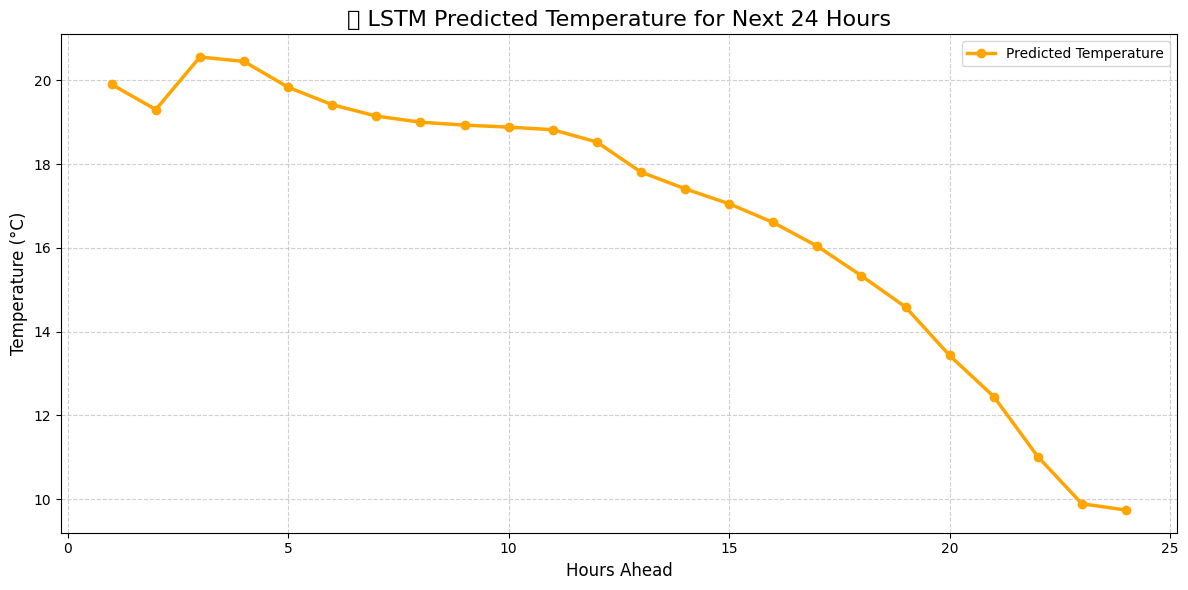


✅ 24-hour forecast completed successfully!


,Hour_Ahead,Predicted_Temperature(°C)
0,1,19.900000
1,2,19.302000
2,3,20.556999
3,4,20.450001
4,5,19.834000
5,6,19.417000
6,7,19.146000
7,8,19.000999
8,9,18.930000
9,10,18.882000


📁 Saved forecast to '../data/processed/next_24hr_forecast.csv'


In [ ]:
from tensorflow.keras.models import load_model

# Load saved LSTM model if not in memory
try:
    model
except NameError:
    print("ℹ️ Loading trained LSTM model from file...")
    model = load_model("models/lstm_temp_model.keras")  # or .h5 if that’s your save format

# ============================================================
# ✅ Cell 7: 24-Hour Future Forecast using LSTM Model
# ============================================================

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

print("\n--- 24-Hour Temperature Forecast using LSTM ---")

# --- 1. Ensure model and sequence data exist ---
try:
    model
    X_test_seq
    y_test_seq
except NameError:
    raise ValueError("❌ LSTM model or test sequences not found. Please re-run Cell 4 before this.")

# --- 2. Get the last available 24-hour input sequence ---
last_seq = X_test_seq[-1:]  # last time window
future_preds = []

# Number of hours to forecast
future_steps = 24

# --- 3. Predict next 24 hours iteratively ---
X_future = last_seq.copy()

for i in range(future_steps):
    next_pred = model.predict(X_future, verbose=0)[0, 0]
    future_preds.append(next_pred)

    # Slide the window forward by adding the new prediction
    # Drop the oldest time step and add the new predicted value
    new_step = X_future[:, -1, :].copy()
    new_step[0, 0] = next_pred  # assuming first feature is temperature-related
    X_future = np.append(X_future[:, 1:, :], new_step.reshape(1, 1, -1), axis=1)

# --- 4. Plot 24-Hour Forecast ---
plt.figure(figsize=(12, 6))
plt.plot(range(1, future_steps + 1), future_preds, marker='o', linewidth=2.5, color='orange', label='Predicted Temperature')
plt.title("🌦️ LSTM Predicted Temperature for Next 24 Hours", fontsize=16)
plt.xlabel("Hours Ahead", fontsize=12)
plt.ylabel("Temperature (°C)", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

# --- 5. Create forecast DataFrame ---
forecast_df = pd.DataFrame({
    "Hour_Ahead": range(1, future_steps + 1),
    "Predicted_Temperature(°C)": future_preds
})

print("\n✅ 24-hour forecast completed successfully!")
display(forecast_df.round(3))

# Optional: Save forecast
forecast_df.to_csv("../data/processed/next_24hr_forecast.csv", index=False)
print("📁 Saved forecast to '../data/processed/next_24hr_forecast.csv'")
